In [2]:
import pandas as pd
from training_claude import load_agent, evaluate_agent
from rl_env import FlexSimEnv
from eval import evaluate_heuristic
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import time
from utils import create_field_from_list_column
from params import ON_TIME_BOUNDS, N_STOPS, MAX_TIME_HOURS, TRIP_WEIGHT, HEURISTIC_BETA
# resolution to 100 dpi
mpl.rcParams['figure.dpi'] = 150

import matplotlib.font_manager as fm

# The correct way to add DM Sans font:
font_path = 'fonts/DM_Sans/static/DMSans-Regular.ttf'  # Path to your DM Sans font file
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'DM Sans'  # Set as default font

In [3]:
# functions
def float_to_str(f):
    return str(f).replace('.', '_')

def get_deviation_totals(state, group_cols=['demand','scenario']):
   non_zero_requests = state[state['n_requests'] > 0].copy()
   
   episode_results = non_zero_requests.groupby(group_cols + ['episode']).agg({
       'n_requests': 'size',
       'action': 'sum'
   }).rename(columns={'n_requests': 'deviation_chances', 'action': 'deviations'})
   
   return episode_results.groupby(group_cols)[['deviation_chances', 'deviations']].mean().round(1).reset_index()

def get_flex_pax_totals(pax, group_cols=['demand','scenario']):
    # rejection rate per episode
    episode_results = pax.groupby(group_cols + ['episode'])[['rejected', 'flex']].sum().reset_index()
    return episode_results.groupby(group_cols)[['rejected', 'flex']].mean().round(1).reset_index()

def get_trips_totals(trips, group_cols=['demand','scenario']):
   terminal_trips = trips[trips['stop']==N_STOPS-1].copy()
   episode_results = terminal_trips.groupby(group_cols + ['episode']).agg({
       'arrival_time': 'size',
       'off_schedule': 'sum'
   }).rename(columns={'arrival_time': 'n_trips'})
   episode_deviations = trips.groupby(group_cols + ['episode']).agg({
       'flex': 'sum',
   }).rename(columns={'flex': 'n_deviations'})
   
   trip_totals = episode_results.groupby(group_cols)[['n_trips', 'off_schedule']].mean().round(1).reset_index()
   deviation_totals = episode_deviations.groupby(group_cols)[['n_deviations']].mean().round(1).reset_index()
   trip_totals = trip_totals.merge(deviation_totals, on=group_cols, how='left')
   return trip_totals

def get_statistical_significance_test(df, scenario1, scenario2, metric):
    """
    Perform a statistical significance test (t-test) between two scenarios for a given metric.
    """
    # Filter the DataFrame for the two scenarios
    scenario1_data = df[df['scenario'] == scenario1][metric]
    scenario2_data = df[df['scenario'] == scenario2][metric]

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(scenario1_data, scenario2_data)

    return round(t_stat,3), round(p_value,3)

def get_acceptance_rate_distributions(pax, group_cols=['demand','scenario']):
    episode_results = pax.groupby(group_cols + ['episode'])[['rejected', 'flex']].sum().reset_index()
    episode_results['acceptance_rate'] = episode_results['flex'] / (episode_results['flex'] + episode_results['rejected'])
    episode_results.drop(columns=['rejected', 'flex'], inplace=True)
    return episode_results

def get_on_schedule_rate_distributions(trips, group_cols=['demand','scenario']):
   terminal_trips = trips[trips['stop']==N_STOPS-1].copy()
   episode_results = terminal_trips.groupby(group_cols + ['episode']).agg({
       'arrival_time': 'size',
       'off_schedule': 'sum'
   }).rename(columns={'arrival_time': 'n_trips'}).reset_index()
   episode_results['on_schedule_rate'] = (episode_results['n_trips'] - episode_results['off_schedule']) / episode_results['n_trips']
   episode_results.drop(columns=['n_trips', 'off_schedule'], inplace=True)
   return episode_results

def get_wait_time_for_group(hw_series):
    avg_headway = hw_series.mean()
    sd_headway = hw_series.std()
    cv_headway = sd_headway / avg_headway
    return cv_headway

def process_history(history_merged, start_time, end_time):
    # pre processing
    # pax
    pax = history_merged['pax'].copy()
    pax = pax[pax['arrival_time'].between(start_time, end_time)]
    pax['arrival_hour'] = (pax['arrival_time']/3600).astype(int)
    pax = pax[pax['arrival_hour']<3]
    pax['rejected'] = (pax['boarding_time'].isna().astype(int)) & (pax['flex'] == 1) # rejected from their perspective
    pax['ride_time'] = pax['alight_time'] - pax['boarding_time']
    pax['method'] = pax['scenario'].apply(
        lambda x: 'RL' if 'dqn' in x else 'heuristic')
    

    # trips
    trips = history_merged['vehicles'].copy()
    trips = trips[trips['arrival_time'].between(start_time, end_time)]
    trips['sch_dev'] = trips['arrival_time'] - trips['scheduled_time']
    trips['hour'] = (trips['arrival_time']/3600).astype(int)
    trips = trips[trips['hour']<3]
    trips['early'] = (trips['sch_dev'] < ON_TIME_BOUNDS[0]).astype(int)
    trips['late'] = (trips['sch_dev'] > ON_TIME_BOUNDS[1]).astype(int)
    trips['on_time'] = (trips['sch_dev'].between(ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

    trips['method'] = trips['scenario'].apply(
        lambda x: 'RL' if 'dqn' in x else 'heuristic')

    trip_status_cols = ['early', 'late', 'on_time']
    # create new column status with the string of the trip status
    trips['status'] = trips[trip_status_cols].idxmax(axis=1)

    trips['off_schedule'] = (~trips['sch_dev'].between(
        ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

    # idle
    idle = history_merged['idle'].copy()
    idle = idle[idle['time'].between(start_time, end_time)]

    # combine all metrics
    trips_totals = get_trips_totals(trips)
    flex_pax_totals = get_flex_pax_totals(pax)
    combined_totals = pd.merge(trips_totals, flex_pax_totals, on=['demand','scenario'])
    combined_totals['method'] = combined_totals['scenario'].apply(
        lambda x: 'RL' if 'dqn' in x else 'heuristic')

    combined_totals['on_schedule_rate'] = (100 - combined_totals['off_schedule'] / combined_totals['n_trips'] * 100).round(1)
    combined_totals['acceptance_rate'] = (100 - combined_totals['rejected'] / combined_totals['flex'] * 100).round(1)
    return combined_totals, pax, trips, idle

def get_eval_data(totals, pax, trips, idle, eval_scenarios_df):
    # get evaluations
    eval_totals = totals.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
    eval_totals['deviations_per_trip'] = (eval_totals['n_deviations'] / eval_totals['n_trips']).round(2)
    eval_pax = pax.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
    eval_trips = trips.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
    eval_idle = idle.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
    return eval_totals, eval_pax, eval_trips, eval_idle

def run_base_scenarios(
        random_seed, demand_scenarios, weights, alphas, n_episodes, main_history):
    for demand in demand_scenarios:
        # heuristic
        for i in range(len(alphas)):
            scenario_name = f'heuristic_{float_to_str(alphas[i])}'
            np.random.seed(random_seed)
            tmp_history = evaluate_heuristic(
                alpha=alphas[i], beta=HEURISTIC_BETA, n_episodes=n_episodes, 
                output_history=True,
                scenario_name=scenario_name, demand_scenario=demand)
            for ky in tmp_history:
                if ky not in main_history:
                    main_history[ky] = []
                tmp_history[ky]['demand'] = demand
                main_history[ky].append(tmp_history[ky])


        # RL
        env = FlexSimEnv(demand_scenario=demand)
        for i in range(len(weights)):
            np.random.seed(random_seed)
            
            model_path = f'models/{demand}/dqn_{float_to_str(weights[i])}.pth'
            scenario_name = f'dqn_{float_to_str(weights[i])}'

            tmp_agent = load_agent(model_path)
            tmp_history, tmp_summary = evaluate_agent(
            env, tmp_agent, num_episodes=n_episodes, output_history=True,
            scenario_name=scenario_name)
            for ky in tmp_history:
                if ky not in main_history:
                    main_history[ky] = []
                tmp_history[ky]['demand'] = demand
                main_history[ky].append(tmp_history[ky])

    history_merged = {}
    # now concatenate within each main key
    for ky in main_history.keys():
        history_merged[ky] = pd.concat(main_history[ky], axis=0)
    return history_merged

def run_sensitivity_scenarios(
        random_seed, demand_scenarios, 
        weights, alphas, travel_time_factor, n_episodes, main_history):
    for demand in demand_scenarios:
        # heuristic
        for i in range(len(alphas)):
            scenario_name = f'heuristic_{float_to_str(alphas[i])}'
            np.random.seed(random_seed)
            tmp_history = evaluate_heuristic(
                alpha=alphas[i], beta=HEURISTIC_BETA, n_episodes=n_episodes, 
                output_history=True,
                scenario_name=scenario_name, demand_scenario=demand)
            for ky in tmp_history:
                if ky not in main_history:
                    main_history[ky] = []
                tmp_history[ky]['demand'] = demand
                tmp_history[ky]['tt_factor'] = travel_time_factor
                main_history[ky].append(tmp_history[ky])


        # RL
        env = FlexSimEnv(demand_scenario=demand)
        for i in range(len(weights)):
            np.random.seed(random_seed)
            
            model_path = f'models/{travel_time_factor}/dqn_{float_to_str(weights[i])}.pth'
            scenario_name = f'dqn_{float_to_str(weights[i])}'

            tmp_agent = load_agent(model_path)
            tmp_history, tmp_summary = evaluate_agent(
            env, tmp_agent, num_episodes=n_episodes, output_history=True,
            scenario_name=scenario_name)
            for ky in tmp_history:
                if ky not in main_history:
                    main_history[ky] = []
                tmp_history[ky]['demand'] = demand
                tmp_history[ky]['tt_factor'] = travel_time_factor
                main_history[ky].append(tmp_history[ky])

    history_merged = {}
    # now concatenate within each main key
    for ky in main_history.keys():
        history_merged[ky] = pd.concat(main_history[ky], axis=0)
    return history_merged

## testing RL rewards

In [3]:
# model_path = f'models/off_peak/dqn_-3_0.pth'
# agent = load_agent(model_path)
# env = FlexSimEnv(demand_scenario='off_peak')

# for episode in range(1):
#     # Start the episode
#     next_observation, info = env.reset()

#     # update observation
#     observation = next_observation
    
#     # select action
#     action = agent.act(observation, eval_mode=True)

#     # take action in environment
#     next_observation, reward, done, terminated, info = env.step(action)

#     while not terminated:
#         if not done:
#             action = agent.act(observation, eval_mode=True)
#         else:
#             action = None
#         observation, reward, done, terminated, info = env.step(action=action)

In [4]:
# df = pd.DataFrame(env.experience_log)
# df['obs'] = df.sort_values(by=['veh_idx', 'time']).groupby(['veh_idx'])['next_obs'].shift(1)
# # move next_obs to the end of columns
# df = df[['veh_idx', 'time','obs', 'next_obs', 'reward', 'done']]

## Full testing

In [5]:
main_history = {
    'pax': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 1

# slope scenarios
alphas = [0.5,1.0, 1.2, 1.5, 1.8]

# model paths 
# weights = [3.0, 3.2, 3.5]
# weights = [-2.7, -3.0, -3.2, -3.5, -3.8]
weights = [-2.0, -3.0, -5.0, -7.0]

In [ ]:
history_merged = run_base_scenarios(
    RANDOM_SEED, ['off_peak', 'peak'], weights, alphas, N_EPISODES, main_history)

## Travel time scenarios

### 5 pct

In [5]:
main_history = {
    'pax': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 1

alphas = [1.2]
weights = [-2.0, -3.0, -5.0, -7.0]
travel_time_factor = 5


history_merged = run_sensitivity_scenarios(
    RANDOM_SEED, ['peak'], weights, alphas, travel_time_factor, N_EPISODES, main_history)

KeyboardInterrupt: 

In [5]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

combined_totals, pax, trips, idle = process_history(
    history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)
combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,peak,dqn_-2_0,30.0,7.9,23.5,11.6,57.1,RL,73.7,79.7
1,peak,dqn_-3_0,29.9,8.2,22.0,15.3,59.0,RL,72.6,74.1
2,peak,dqn_-5_0,29.7,7.8,21.7,15.7,58.6,RL,73.7,73.2
3,peak,dqn_-7_0,29.9,7.4,22.6,14.7,59.3,RL,75.3,75.2
4,peak,heuristic_1_2,29.8,9.0,23.7,11.5,59.1,heuristic,69.8,80.5


In [ ]:
eval_scenarios_5 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-2_0', 'heuristic_1_2'],
}

In [12]:
# create folder named with format of "experiments_mmddhhmmss"
folder_name = time.strftime("experiments_%m%d_%H%M%S")
# folder_name = time.strftime("experiments_working")
os.makedirs(f'outputs/{folder_name}_tt_5', exist_ok=True)
# save each dataframe in history_merged to a csv file in the folder
for ky in history_merged:
    history_merged[ky].to_csv(f'outputs/{folder_name}_tt_5/{ky}.csv', index=False)

### 10 pct

In [40]:
main_history = {
    'pax': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 3

alphas = [1.2]
weights = [-7.5, -8.0, -8.5]
travel_time_factor = 10

history_merged = run_sensitivity_scenarios(
    RANDOM_SEED, ['peak'], weights, alphas, travel_time_factor, N_EPISODES, main_history)

In [41]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

combined_totals, pax, trips, idle = process_history(
    history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)
combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,peak,dqn_-7_5,29.9,9.0,21.7,13.7,57.0,RL,69.9,76.0
1,peak,dqn_-8_0,29.8,8.8,23.5,12.8,58.1,RL,70.5,78.0
2,peak,dqn_-8_5,30.0,9.5,23.3,13.5,57.7,RL,68.3,76.6
3,peak,heuristic_1_2,29.7,10.1,22.7,11.2,57.6,heuristic,66.0,80.6


In [42]:
eval_scenarios_10 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-8_0', 'heuristic_1_2'],
}

In [43]:
# create folder named with format of "experiments_mmddhhmmss"
folder_name = time.strftime("experiments_%m%d_%H%M%S")
# folder_name = time.strftime("experiments_working")
os.makedirs(f'outputs/{folder_name}_tt_10', exist_ok=True)
# save each dataframe in history_merged to a csv file in the folder
for ky in history_merged:
    history_merged[ky].to_csv(f'outputs/{folder_name}_tt_10/{ky}.csv', index=False)

### 15 pct

In [4]:
main_history = {
    'pax': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 1

alphas = [1.2]
weights = [-2.0, -3.0, -5.0, -7.0]
travel_time_factor = 15

history_merged = run_sensitivity_scenarios(
    RANDOM_SEED, ['peak'], weights, alphas, travel_time_factor, N_EPISODES, main_history)

In [5]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

combined_totals, pax, trips, idle = process_history(
    history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)
combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,peak,dqn_-2_0,30.0,9.4,21.5,14.5,57.9,RL,68.7,75.0
1,peak,dqn_-3_0,29.9,8.6,22.1,15.2,58.8,RL,71.2,74.1
2,peak,dqn_-5_0,30.0,8.9,24.6,9.9,56.2,RL,70.3,82.4
3,peak,dqn_-7_0,30.0,8.2,23.8,11.7,57.1,RL,72.7,79.5
4,peak,heuristic_1_2,29.6,10.0,22.7,11.5,57.8,heuristic,66.2,80.1


In [6]:
eval_scenarios_15 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-5_0', 'heuristic_1_2'],
}

In [8]:
# create folder named with format of "experiments_mmddhhmmss"
folder_name = time.strftime("experiments_%m%d_%H%M%S")
# folder_name = time.strftime("experiments_working")
os.makedirs(f'outputs/{folder_name}_tt_15', exist_ok=True)
# save each dataframe in history_merged to a csv file in the folder
for ky in history_merged:
    history_merged[ky].to_csv(f'outputs/{folder_name}_tt_15/{ky}.csv', index=False)

### 20 pct

In [3]:
main_history = {
    'pax': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 1

alphas = [1.2]
weights = [-2.0, -3.0, -5.0, -7.0]
travel_time_factor = 20

history_merged = run_sensitivity_scenarios(
    RANDOM_SEED, ['peak'], weights, alphas, travel_time_factor, N_EPISODES, main_history)

In [4]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

combined_totals, pax, trips, idle = process_history(
    history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)
combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,peak,dqn_-2_0,29.9,9.5,24.0,11.7,58.1,RL,68.2,79.9
1,peak,dqn_-3_0,30.0,9.5,22.8,13.1,57.7,RL,68.3,77.3
2,peak,dqn_-5_0,30.1,9.8,23.2,13.0,57.4,RL,67.4,77.4
3,peak,dqn_-7_0,30.3,9.5,22.6,14.5,57.9,RL,68.6,75.0
4,peak,heuristic_1_2,29.9,10.7,22.8,11.4,59.2,heuristic,64.2,80.7


In [5]:
eval_scenarios_20 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-2_0', 'heuristic_1_2'],
}

In [6]:
# create folder named with format of "experiments_mmddhhmmss"
folder_name = time.strftime("experiments_%m%d_%H%M%S")
# folder_name = time.strftime("experiments_working")
os.makedirs(f'outputs/{folder_name}_tt_20', exist_ok=True)
# save each dataframe in history_merged to a csv file in the folder
for ky in history_merged:
    history_merged[ky].to_csv(f'outputs/{folder_name}_tt_20/{ky}.csv', index=False)

## Write

In [ ]:
# # create folder named with format of "experiments_mmddhhmmss"
# folder_name = time.strftime("experiments_%m%d_%H%M%S")
# # folder_name = time.strftime("experiments_working")
# os.makedirs(f'outputs/{folder_name}', exist_ok=True)
# # save each dataframe in history_merged to a csv file in the folder
# for ky in history_merged:
#     history_merged[ky].to_csv(f'outputs/{folder_name}/{ky}.csv', index=False)

## Evaluation (4) with action masking for delays > 50 and travel time sensitivity

In [82]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

eval_scenarios_0 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-7_0', 'heuristic_1_2'],
}

eval_scenarios_5 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-2_0', 'heuristic_1_2'],
}

eval_scenarios_10 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-8_0', 'heuristic_1_2'],
}

eval_scenarios_15 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-5_0', 'heuristic_1_2'],
}

eval_scenarios_20 = {
    'demand': ['peak', 'peak'],
    'scenario': ['dqn_-2_0', 'heuristic_1_2'],
}

lst_eval_scenarios = [
    eval_scenarios_0,
    eval_scenarios_5,
    eval_scenarios_10,
    eval_scenarios_15,
    eval_scenarios_20
]

folder_names = [
    "experiments_" + "0515_133208",
    'experiments_0519_152357_tt_5',
    'experiments_0602_122730_tt_10',
    'experiments_0519_152905_tt_15',
    'experiments_0519_153741_tt_20'
]

tt_factors = [0, 5, 10, 15, 20]
factors = [1.00, 1.05, 1.10, 1.15, 1.20]

all_eval_totals = []
all_pax_totals = []
all_trips_totals = []

for i, folder_name in enumerate(folder_names):
    # read 
    history_merged = {'pax': [], 'vehicles': [], 'idle': []}

    for ky in history_merged:
        # read the csv file
        history_merged[ky] = pd.read_csv(f'outputs/{folder_name}/{ky}.csv')

    combined_totals, pax, trips, idle = process_history(
        history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)

    eval_scenarios_df = pd.DataFrame(lst_eval_scenarios[i])

    eval_totals, eval_pax, eval_trips, eval_idle = get_eval_data(
        combined_totals, pax, trips, idle, eval_scenarios_df)
    
    eval_totals['tt_factor'] = tt_factors[i]
    eval_pax['tt_factor'] = tt_factors[i]
    eval_trips['tt_factor'] = tt_factors[i]
    all_pax_totals.append(eval_pax)
    all_trips_totals.append(eval_trips)
    all_eval_totals.append(eval_totals)

In [81]:
extract_cols = ['tt_factor','method', 'n_deviations', 
                'deviations_per_trip','on_schedule_rate', 
                'acceptance_rate']
totals_df = pd.concat(all_eval_totals, ignore_index=True)[extract_cols]
totals_df['factor'] = 1 + totals_df['tt_factor']/100
pax_df = pd.concat(all_pax_totals, ignore_index=True)
trips_df = pd.concat(all_trips_totals, ignore_index=True)
trips_df['factor'] = 1 + trips_df['tt_factor']/100
trips_df['sch_dev']/=60

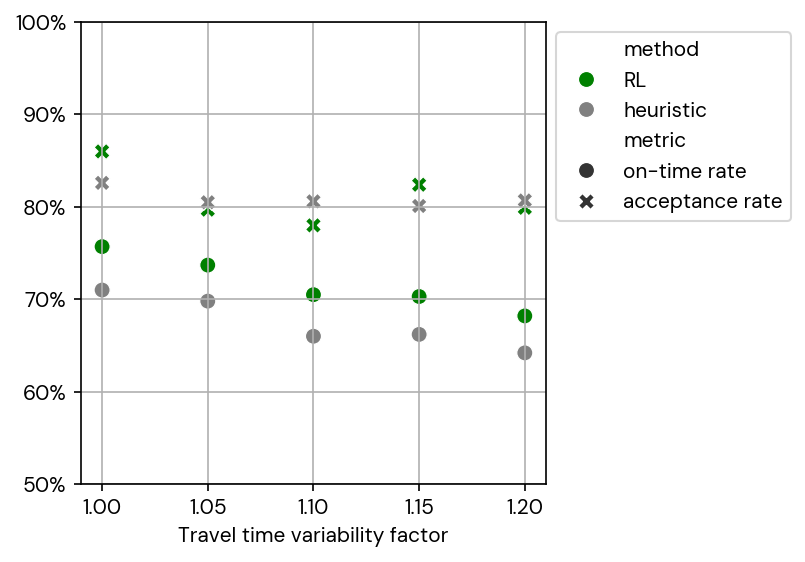

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to long format: one row per (factor, value, method, metric)
long_df = pd.melt(
    totals_df,
    id_vars=['factor', 'method'],
    value_vars=['on_schedule_rate', 'acceptance_rate'],
    var_name='metric',
    value_name='value'
)

# Optional: make metric names more human-readable
long_df['metric'] = long_df['metric'].map({
    'on_schedule_rate': 'on-time rate',
    'acceptance_rate': 'acceptance rate'
})

# Plot with seaborn using hue and style
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    data=long_df,
    x='factor', y='value',
    hue='method',
    style='metric',
    palette=['green', 'gray'],
    s=60,
    ax=ax
)

# Customize y-axis
ax.set_ylim(50, 95)
ax.set_yticks(np.arange(50, 101, 10))
ax.set_yticklabels([f'{i}%' for i in np.arange(50, 101, 10)])
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),)
ax.set_ylabel('')
ax.set_xlabel('Travel time variability factor')
ax.grid()

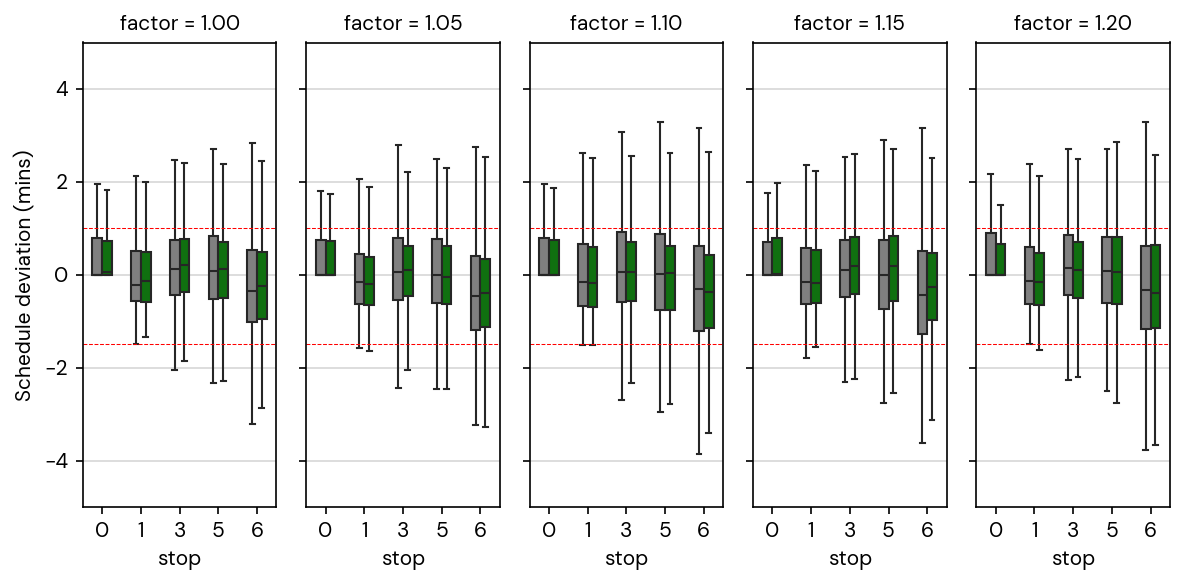

In [85]:
fig, axs = plt.subplots(figsize=(8, 4), ncols=5, sharey=True)
for i, tt_factor in enumerate(factors):
    sns.boxplot(
        data=trips_df[(trips_df['factor']==tt_factor) & (trips_df['direction']=='out') & (~trips_df['stop'].isin([2,4]))], 
        x='stop', y='sch_dev',
        hue='method', showfliers=False, ax=axs[i], palette=['gray', 'green'], width=0.5,
    )
    axs[i].legend().remove()
    axs[i].grid(axis='y', alpha=0.5)
    axs[i].set_title(f'factor = {tt_factor:.2f}', fontsize=10)
    axs[i].axhline(ON_TIME_BOUNDS[0]/60, color='red', linestyle='--', linewidth=0.5)
    axs[i].axhline(ON_TIME_BOUNDS[1]/60, color='red', linestyle='--', linewidth=0.5)
axs[0].set_ylim(-5, 5)
axs[0].set_ylabel('Schedule deviation (mins)')
plt.tight_layout()

In [58]:
# fig, axs = plt.subplots(figsize=(4,4))
# sns.boxplot(
#     data=pax_df[(pax_df['flex']==0) & (pax_df['direction']=='out') & (pax_df['origin']>0)], 
#     x='tt_factor', y='wait_time',
#     hue='method', palette=['gray', 'green'], ax=axs, 
#     fliersize=0.4, linewidth=1.5, width=0.5
# )
# axs.grid(axis='y')

## Evaluation (3) with action masking for delays > 50 seconds

In [4]:
# read 
history_merged = {'pax': [], 'vehicles': [], 'idle': []}

# lets process the reading of csv files
folder_name = "experiments_" + "0515_133208" 
for ky in history_merged:
    # read the csv file
    history_merged[ky] = pd.read_csv(f'outputs/{folder_name}/{ky}.csv')

In [5]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

combined_totals, pax, trips, idle = process_history(
    history_merged, start_time=ANALYSIS_START_TIME, end_time=ANALYSIS_END_TIME)

# combined_totals

In [6]:
eval_scenarios_dict = {
    'demand': ['off_peak', 'off_peak', 'peak', 'peak'],
    'scenario': ['dqn_-3_0', 'heuristic_1_0', 'dqn_-7_0', 'heuristic_1_2'],
}
eval_scenarios_df = pd.DataFrame(eval_scenarios_dict)

eval_totals, eval_pax, eval_trips, eval_idle = get_eval_data(
    combined_totals, pax, trips, idle, eval_scenarios_df)

# trip stats
group_cols = ['demand', 'scenario',]
trip_status_cols = ['early', 'on_time', 'late']
per_episode = eval_trips[eval_trips['stop']==N_STOPS-1].groupby(group_cols + ['episode'])[trip_status_cols].sum().reset_index()
trip_counts = per_episode.groupby(group_cols)[trip_status_cols].mean().reset_index()
trip_counts['total'] = trip_counts['early'] + trip_counts['late'] + trip_counts['on_time']
for col in trip_status_cols:
    trip_counts[col] = (trip_counts[col] / trip_counts['total'] * 100).round(2)

In [7]:
eval_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate,deviations_per_trip
0,off_peak,dqn_-3_0,30.4,7.2,28.8,10.0,70.3,RL,76.3,85.8,0.95
1,off_peak,heuristic_1_0,29.9,9.0,28.7,10.0,74.3,heuristic,69.9,86.5,0.96
2,peak,dqn_-7_0,30.1,7.3,25.9,7.8,55.6,RL,75.7,86.0,0.86
3,peak,heuristic_1_2,30.0,8.7,23.7,9.8,56.3,heuristic,71.0,82.6,0.79


In [8]:
per_episode = eval_trips[eval_trips['flex']==1].groupby(
    group_cols + ['direction','stop','episode']).size().reset_index(name='n_served')
flex_served = per_episode.groupby(
    group_cols + ['direction','stop'])['n_served'].mean().round(1).reset_index()

patterns = flex_served.pivot(
    index=['demand', 'scenario','direction'],
    columns='stop',
    values='n_served'
)
((patterns[4])/(patterns[2] + patterns[4])).reset_index(name='pct_second')

,demand,scenario,direction,pct_second
0,off_peak,dqn_-3_0,in,0.375839
1,off_peak,dqn_-3_0,out,0.371429
2,off_peak,heuristic_1_0,in,0.367347
3,off_peak,heuristic_1_0,out,0.347518
4,peak,dqn_-7_0,in,0.352000
5,peak,dqn_-7_0,out,0.335821
6,peak,heuristic_1_2,in,0.365217
7,peak,heuristic_1_2,out,0.344262


In [9]:
per_episode = eval_pax[eval_pax['flex']==1].groupby(
    group_cols + ['direction', 'origin','episode']).size().reset_index(name='n_served')
flex_served = per_episode.groupby(
    group_cols + ['direction','origin'])['n_served'].mean().round(1).reset_index()

patterns = flex_served.pivot(
    index=['demand', 'scenario','direction'],
    columns='origin',
    values='n_served'
)
# ((patterns[4])/(patterns[2] + patterns[4])).reset_index(name='pct_second')

In [10]:
patterns

origin                               2     4
demand   scenario      direction            
off_peak dqn_-3_0      in         24.2  12.0
                       out        23.1  10.9
         heuristic_1_0 in         23.9  13.2
                       out        25.2  12.0
peak     dqn_-7_0      in         18.7   8.9
                       out        18.9   9.1
         heuristic_1_2 in         18.5   8.8
                       out        19.2   9.8

In [11]:
# served['deviation_prob'] = (served['n_served'] / served['total']).round(2)

# served=served[group_cols + ['direction', 'stop', 'deviation_prob']]

In [12]:
# served.pivot(
#     index=['demand', 'direction', 'stop'],
#     columns='scenario',
#     values='deviation_prob'
# )

In [13]:
0.35/(0.35+0.59), 0.33/(0.33+0.61)

(0.3723404255319149, 0.3510638297872341)

In [14]:
0.3/0.89, 0.28/0.81

(0.33707865168539325, 0.34567901234567905)

In [15]:
# Start with your original data
cols_to_show = ['demand', 'method', 'deviations_per_trip', 'on_schedule_rate', 'acceptance_rate']
table_data = eval_totals[cols_to_show].copy()
table_data['demand'] = table_data['demand'].replace({'off_peak': 'Off-peak', 'peak': 'Peak'})

# Melt the table to transform it from wide to long format
melted_data = table_data.melt(
    id_vars=['demand', 'method'], 
    value_vars=['deviations_per_trip', 'on_schedule_rate', 'acceptance_rate'],
    var_name='metric', 
    value_name='value'
)

# Create a pivot table with metric as index, and demand and method as columns
result_table = melted_data.pivot_table(
    index='metric',
    columns=['demand', 'method'],
    values='value'
)

# Rename the metrics for better readability
metric_names = {
    'deviations_per_trip': 'Deviations per Trip',
    'on_schedule_rate': 'On Schedule Rate (%)',
    'acceptance_rate': 'Acceptance Rate (%)'
}

result_table.index = result_table.index.map(lambda x: metric_names.get(x, x))
result_table.index.name = 'Metric'
result_table.columns.names = ['Demand', 'Method']
result_table

Demand               Off-peak             Peak          
Method                     RL heuristic     RL heuristic
Metric                                                  
Acceptance Rate (%)     85.80     86.50  86.00     82.60
Deviations per Trip      0.95      0.96   0.86      0.79
On Schedule Rate (%)    76.30     69.90  75.70     71.00

In [16]:
# print(result_table.to_latex(float_format='%.2f', caption='Evaluation Results', label='tab:evaluation_results',))

In [17]:
trip_counts

,demand,scenario,early,on_time,late,total
0,off_peak,dqn_-3_0,10.09,76.43,13.49,30.400000
1,off_peak,heuristic_1_0,11.72,69.98,18.30,29.866667
2,peak,dqn_-7_0,12.85,75.64,11.52,30.100000
3,peak,heuristic_1_2,14.89,71.00,14.11,30.000000


In [18]:
trip_status_counts = eval_trips[eval_trips['stop']==N_STOPS-1].groupby(group_cols)[trip_status_cols].sum().reset_index()
trip_status_counts['total'] = trip_status_counts['early'] + trip_status_counts['late'] + trip_status_counts['on_time']
for col in trip_status_cols:
    trip_status_counts[col] = (trip_status_counts[col] / trip_status_counts['total'] * 100).round(2)

In [19]:
trip_status_counts

,demand,scenario,early,on_time,late,total
0,off_peak,dqn_-3_0,10.09,76.43,13.49,912
1,off_peak,heuristic_1_0,11.72,69.98,18.30,896
2,peak,dqn_-7_0,12.85,75.64,11.52,903
3,peak,heuristic_1_2,14.89,71.00,14.11,900


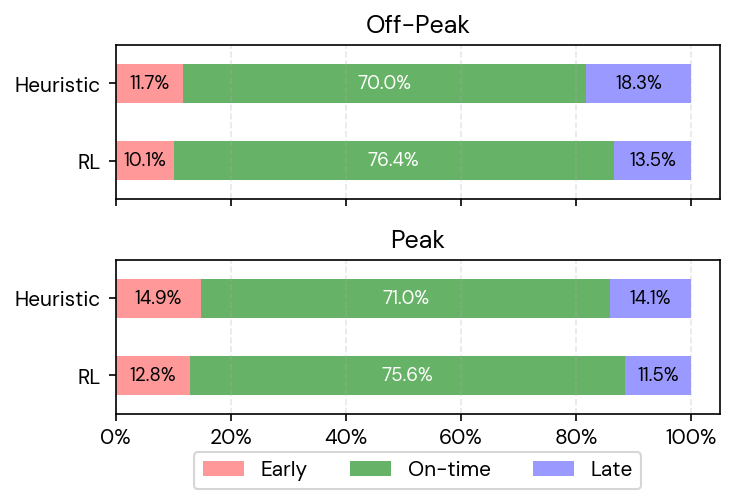

In [20]:
fig, axs = plt.subplots(figsize=(5, 3.5), nrows=2, ncols=1, sharex=True)

# Use the same colors across both plots
colors = ['#ff9999', '#66b266', '#9999ff']  # Lighter versions for better visibility

# off peak scenario
for i, demand in enumerate(['off_peak', 'peak']):
    tmp_df = trip_status_counts[trip_status_counts['demand'] == demand].copy()
    tmp_df['scenario'] = tmp_df['scenario'].apply(lambda x: 'RL' if 'dqn' in x else 'Heuristic')
    tmp_df = tmp_df[['scenario', 'early', 'on_time', 'late']]
    tmp_df = tmp_df.set_index('scenario')

    # Plot horizontal stacked bars
    bars = tmp_df.plot(kind='barh', stacked=True, ax=axs[i], color=colors)
    
    # Add labels to each bar segment
    for j, scenario in enumerate(tmp_df.index):
        # Get the values for this scenario
        values = tmp_df.loc[scenario].values
        
        # Calculate cumulative positions for label placement
        cumulative = 0
        for k, (col, value) in enumerate(zip(tmp_df.columns, values)):
            if value > 0:  # Only add label if value is greater than 0
                # Position label in the middle of the segment
                label_x = cumulative + value / 2
                label_y = j
                
                # Add percentage label
                axs[i].text(label_x, label_y, f'{value:.1f}%', 
                           ha='center', va='center', 
                           fontweight='bold', fontsize=9,
                           color='white' if k == 1 else 'black')  # White text for green bars
            
            cumulative += value
    
    axs[i].set_title(demand.replace('_', '-').title())
    axs[i].grid(axis='x', linestyle='--', alpha=0.3)
    
    # Remove y-label and add percentage sign to x-axis
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
    # Legend only for the second plot
    if i == 0:
        axs[i].legend().remove()
    else:
        axs[i].legend(['Early', 'On-time', 'Late'], loc='upper center', 
                      bbox_to_anchor=(0.5, -0.18), ncol=3)
axs[1].set_xticks(np.arange(0, 101, 20))
axs[1].set_xticklabels([f'{i}%' for i in np.arange(0, 101, 20)])
plt.tight_layout()

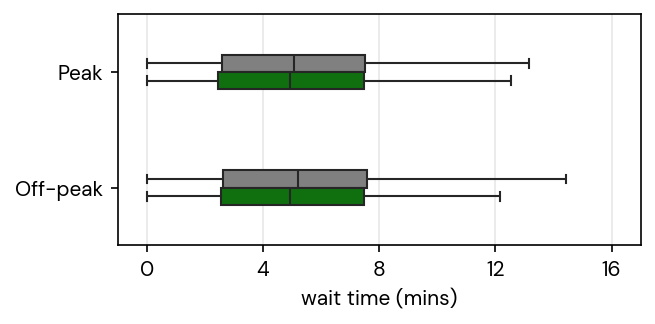

In [53]:
fig, axs = plt.subplots(figsize=(4.5, 2.0))
tmp_df = eval_pax[(eval_pax['flex']==0)].copy()
tmp_out_df = tmp_df[(tmp_df['direction'] == 'out')].copy()
tmp_out_df = tmp_out_df[tmp_out_df['origin'] > 0].copy()
tmp_out_df['wait_time'] /= 60 
sns.boxplot(data=tmp_out_df, x='wait_time', y='demand', ax=axs, 
            palette=['gray', 'green'], hue='method', width=0.3, orient='h')
axs.legend().remove()
axs.set_xlabel('wait time (mins)')
axs.set_ylabel('')
axs.set_yticks([0, 1], ['Peak', 'Off-peak'])
axs.grid(axis='x', alpha=0.3)
axs.set_xlim(-1, 17)
_=axs.set_xticks(np.arange(0, 19, 4))

In [45]:
eval_pax.groupby(['demand', 'flex', 'scenario'])['wait_time'].quantile(0.97).round(2)

demand    flex  scenario     
off_peak  0     dqn_-3_0         613.25
                heuristic_1_0    633.22
          1     dqn_-3_0         826.59
                heuristic_1_0    805.02
peak      0     dqn_-7_0         613.87
                heuristic_1_2    631.13
          1     dqn_-7_0         802.21
                heuristic_1_2    820.48
Name: wait_time, dtype: float64

In [18]:
eval_trips.groupby(['demand', 'scenario'])['load'].describe().round(2)

count  mean   std  min  25%  50%  75%   max
demand   scenario                                                   
off_peak dqn_-3_0       5378.0  3.88  2.98  0.0  1.0  4.0  6.0  17.0
         heuristic_1_0  5355.0  3.98  3.07  0.0  2.0  4.0  6.0  17.0
peak     dqn_-7_0       5282.0  4.45  3.31  0.0  2.0  4.0  7.0  18.0
         heuristic_1_2  5210.0  4.44  3.33  0.0  2.0  4.0  7.0  20.0

In [19]:
eval_idle.groupby(['demand', 'scenario'])[['idle_time']].mean().round(1).reset_index()

,demand,scenario,idle_time
0,off_peak,dqn_-3_0,22.9
1,off_peak,heuristic_1_0,23.9
2,peak,dqn_-7_0,26.6
3,peak,heuristic_1_2,30.7


## Evaluation (2) with action masking for delays > 1 minute

In [ ]:
# read 
history_merged = {'pax': [], 'vehicles': [], 'idle': []}

# lets process the reading of csv files
folder_name = "experiments_" + "0515_124420" 
for ky in history_merged:
    # read the csv file
    history_merged[ky] = pd.read_csv(f'outputs/{folder_name}/{ky}.csv')

In [7]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

# pre processing
# pax
pax = history_merged['pax'].copy()
pax = pax[pax['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
pax['arrival_hour'] = (pax['arrival_time']/3600).astype(int)
pax = pax[pax['arrival_hour']<3]
pax['rejected'] = (pax['boarding_time'].isna().astype(int)) & (pax['flex'] == 1) # rejected from their perspective
pax['ride_time'] = pax['alight_time'] - pax['boarding_time']

# trips
trips = history_merged['vehicles'].copy()
trips = trips[trips['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
trips['sch_dev'] = trips['arrival_time'] - trips['scheduled_time']
trips['hour'] = (trips['arrival_time']/3600).astype(int)
trips = trips[trips['hour']<3]
trips['early'] = (trips['sch_dev'] < ON_TIME_BOUNDS[0]).astype(int)
trips['late'] = (trips['sch_dev'] > ON_TIME_BOUNDS[1]).astype(int)
trips['on_time'] = (trips['sch_dev'].between(ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

trip_status_cols = ['early', 'late', 'on_time']
# create new column status with the string of the trip status
trips['status'] = trips[trip_status_cols].idxmax(axis=1)

trips['off_schedule'] = (~trips['sch_dev'].between(
    ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

# idle
idle = history_merged['idle'].copy()
idle = idle[idle['time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]

# combine all metrics
trips_totals = get_trips_totals(trips)
flex_pax_totals = get_flex_pax_totals(pax)
combined_totals = pd.merge(trips_totals, flex_pax_totals, on=['demand','scenario'])
combined_totals['method'] = combined_totals['scenario'].apply(
    lambda x: 'RL' if 'dqn' in x else 'heuristic')

combined_totals['on_schedule_rate'] = (100 - combined_totals['off_schedule'] / combined_totals['n_trips'] * 100).round(1)
combined_totals['acceptance_rate'] = (100 - combined_totals['rejected'] / combined_totals['flex'] * 100).round(1)
combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,off_peak,dqn_-2_0,30.0,6.8,26.9,13.4,73.1,RL,77.3,81.7
1,off_peak,dqn_-3_0,30.3,7.8,29.1,10.4,70.6,RL,74.3,85.3
2,off_peak,dqn_-5_0,29.7,7.6,27.1,11.2,70.4,RL,74.4,84.1
3,off_peak,dqn_-7_0,29.9,7.0,26.8,13.1,73.5,RL,76.6,82.2
4,off_peak,heuristic_0_5,29.8,9.0,29.5,7.4,70.6,heuristic,69.8,89.5
5,off_peak,heuristic_1_0,29.9,9.0,28.7,10.0,74.3,heuristic,69.9,86.5
6,off_peak,heuristic_1_2,29.8,8.4,26.3,11.1,72.4,heuristic,71.8,84.7
7,off_peak,heuristic_1_5,29.7,8.4,24.2,13.6,71.0,heuristic,71.7,80.8
8,off_peak,heuristic_1_8,30.1,9.3,22.0,15.8,70.6,heuristic,69.1,77.6
9,peak,dqn_-2_0,30.0,7.6,24.0,10.5,58.8,RL,74.7,82.1


In [ ]:
eval_scenarios_dict = {
    'demand': ['off_peak', 'off_peak', 'peak', 'peak'],
    'scenario': ['dqn_-3_0', 'heuristic_1_0', 'dqn_-7_0', 'heuristic_1_2'],
}
eval_scenarios_df = pd.DataFrame(eval_scenarios_dict)

# get evaluations
eval_totals = combined_totals.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_totals['deviations_per_trip'] = (eval_totals['n_deviations'] / eval_totals['n_trips']).round(2)
eval_pax = pax.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_trips = trips.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_idle = idle.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')

# trip stats
group_cols = ['demand', 'scenario',]
trip_status_cols = ['early', 'on_time', 'late']
per_episode = eval_trips[eval_trips['stop']==N_STOPS-1].groupby(group_cols + ['episode'])[trip_status_cols].sum().reset_index()
trip_counts = per_episode.groupby(group_cols)[trip_status_cols].mean().reset_index()
trip_counts['total'] = trip_counts['early'] + trip_counts['late'] + trip_counts['on_time']
for col in trip_status_cols:
    trip_counts[col] = (trip_counts[col] / trip_counts['total'] * 100).round(2)

In [8]:
# Start with your original data
cols_to_show = ['demand', 'method', 'deviations_per_trip', 'on_schedule_rate', 'acceptance_rate']
table_data = eval_totals[cols_to_show].copy()
table_data['demand'] = table_data['demand'].replace({'off_peak': 'Off-peak', 'peak': 'Peak'})

# Melt the table to transform it from wide to long format
melted_data = table_data.melt(
    id_vars=['demand', 'method'], 
    value_vars=['deviations_per_trip', 'on_schedule_rate', 'acceptance_rate'],
    var_name='metric', 
    value_name='value'
)

# Create a pivot table with metric as index, and demand and method as columns
result_table = melted_data.pivot_table(
    index='metric',
    columns=['demand', 'method'],
    values='value'
)

# Rename the metrics for better readability
metric_names = {
    'deviations_per_trip': 'Deviations per Trip',
    'on_schedule_rate': 'On Schedule Rate (%)',
    'acceptance_rate': 'Acceptance Rate (%)'
}

result_table.index = result_table.index.map(lambda x: metric_names.get(x, x))
result_table.index.name = 'Metric'
result_table.columns.names = ['Demand', 'Method']
result_table

Demand               Off-peak             Peak          
Method                     RL heuristic     RL heuristic
Metric                                                  
Acceptance Rate (%)     85.80     86.50  86.00     82.60
Deviations per Trip      0.95      0.96   0.86      0.79
On Schedule Rate (%)    76.30     69.90  75.70     71.00

In [66]:
print(result_table.to_latex(float_format='%.1f'))

\begin{tabular}{lrrrr}
\toprule
Demand & \multicolumn{2}{l}{Off-peak} & \multicolumn{2}{l}{Peak} \\
Method &       RL & heuristic &   RL & heuristic \\
Metric               &          &           &      &           \\
\midrule
Acceptance Rate (\%)  &     84.1 &      80.8 & 85.8 &      82.6 \\
Deviations per Trip  &      0.9 &       0.8 &  0.9 &       0.8 \\
On Schedule Rate (\%) &     74.4 &      71.7 & 74.3 &      71.0 \\
\bottomrule
\end{tabular}



/var/folders/rq/6t5r60ln34ldkfgfbvb_dfvh0000gn/T/ipykernel_70179/206103768.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_table.to_latex(float_format='%.1f'))


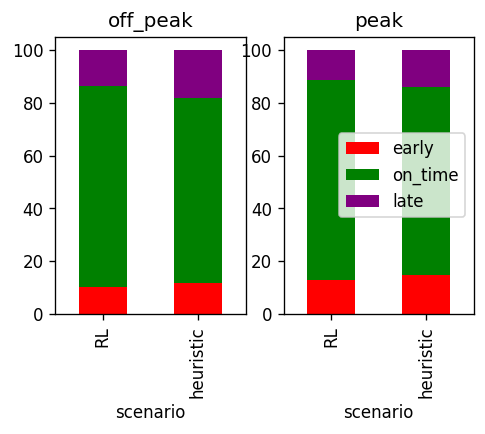

In [9]:
fig, axs = plt.subplots(figsize=(4.5, 3), nrows=1, ncols=2)

# off peak scenario
for i, demand in enumerate(['off_peak', 'peak']):
    tmp_df = trip_counts[trip_counts['demand'] == demand].copy()
    tmp_df['scenario'] = tmp_df['scenario'].apply(lambda x: 'RL' if 'dqn' in x else 'heuristic')
    tmp_df = tmp_df[['scenario', 'early', 'on_time', 'late']]
    tmp_df = tmp_df.set_index('scenario')

    tmp_df.plot(kind='bar', stacked=True, ax=axs[i], color=['red', 'green', 'purple'])
    axs[i].set_title(demand)
    if i == 0:
        axs[i].legend().remove()

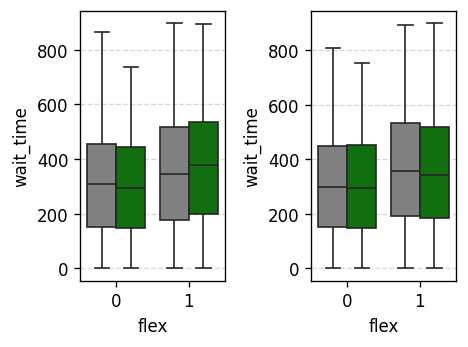

In [10]:
fig, axs = plt.subplots(figsize=(4.0, 3), ncols=2)
for i, demand in enumerate(['off_peak', 'peak']):    
    tmp_df = eval_pax[eval_pax['demand'] == demand].copy()
    tmp_out_df = tmp_df[tmp_df['direction'] == 'out'].copy()
    sns.boxplot(data=tmp_out_df, x='flex', y='wait_time', ax=axs[i], palette=['gray', 'green'], hue='scenario')
    axs[i].legend().remove()
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()


In [11]:
eval_trips.groupby(['demand', 'scenario'])['load'].describe().round(2)

count  mean   std  min  25%  50%  75%   max
demand   scenario                                                   
off_peak dqn_-3_0       5378.0  3.88  2.98  0.0  1.0  4.0  6.0  17.0
         heuristic_1_0  5355.0  3.98  3.07  0.0  2.0  4.0  6.0  17.0
peak     dqn_-7_0       5282.0  4.45  3.31  0.0  2.0  4.0  7.0  18.0
         heuristic_1_2  5210.0  4.44  3.33  0.0  2.0  4.0  7.0  20.0

In [74]:
eval_idle.groupby(['demand', 'scenario'])[['idle_time']].mean().round(1).reset_index()

,demand,scenario,idle_time
0,off_peak,dqn_-5_0,27.1
1,off_peak,heuristic_1_5,32.1
2,peak,dqn_-7_0,26.1
3,peak,heuristic_1_2,30.7


## Evaluation (April)

Read

In [ ]:
# read 
history_merged = {'pax': [], 'vehicles': [], 'idle': []}

# lets process the reading of csv files
folder_name = "experiments_" + "202004" 
for ky in history_merged:
    # read the csv file
    history_merged[ky] = pd.read_csv(f'outputs/{folder_name}/{ky}.csv')

Pre-process

In [121]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

# pre processing
# pax
pax = history_merged['pax'].copy()
pax = pax[pax['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
pax['arrival_hour'] = (pax['arrival_time']/3600).astype(int)
pax = pax[pax['arrival_hour']<3]
pax['rejected'] = (pax['boarding_time'].isna().astype(int)) & (pax['flex'] == 1) # rejected from their perspective
pax['ride_time'] = pax['alight_time'] - pax['boarding_time']

# trips
trips = history_merged['vehicles'].copy()
trips = trips[trips['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
trips['sch_dev'] = trips['arrival_time'] - trips['scheduled_time']
trips['hour'] = (trips['arrival_time']/3600).astype(int)
trips = trips[trips['hour']<3]
trips['early'] = (trips['sch_dev'] < ON_TIME_BOUNDS[0]).astype(int)
trips['late'] = (trips['sch_dev'] > ON_TIME_BOUNDS[1]).astype(int)
trips['on_time'] = (trips['sch_dev'].between(ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

trip_status_cols = ['early', 'late', 'on_time']
# create new column status with the string of the trip status
trips['status'] = trips[trip_status_cols].idxmax(axis=1)

trips['off_schedule'] = (~trips['sch_dev'].between(
    ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

# idle
idle = history_merged['idle'].copy()
idle = idle[idle['time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]

# combine all metrics
trips_totals = get_trips_totals(trips)
# deviation_totals = get_deviation_totals(state)
flex_pax_totals = get_flex_pax_totals(pax)
# combined_totals = pd.merge(trips_totals, deviation_totals, on='scenario')
combined_totals = pd.merge(trips_totals, flex_pax_totals, on=['demand','scenario'])
combined_totals['method'] = combined_totals['scenario'].apply(lambda x: 'RL' if 'dqn' in x else 'heuristic')

combined_totals['on_schedule_rate'] = (100 - combined_totals['off_schedule'] / combined_totals['n_trips'] * 100).round(2)
combined_totals['acceptance_rate'] = (100 - combined_totals['rejected'] / combined_totals['flex'] * 100).round(2)

combined_totals

,demand,scenario,n_trips,off_schedule,n_deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,off_peak,dqn_-2_7,29.7,8.9,22.7,27.2,72.7,RL,70.03,62.59
1,off_peak,dqn_-3_0,25.9,15.9,33.8,9.2,72.3,RL,38.61,87.28
2,off_peak,dqn_-3_2,29.9,6.1,30.3,11.3,71.7,RL,79.60,84.24
3,off_peak,dqn_-3_5,29.9,10.7,20.5,35.3,71.9,RL,64.21,50.90
4,off_peak,dqn_-3_8,26.4,15.5,34.7,8.3,73.6,RL,41.29,88.72
5,off_peak,heuristic_1_0,30.0,8.5,29.5,7.9,71.3,heuristic,71.67,88.92
6,off_peak,heuristic_1_2,30.1,8.0,28.3,10.0,70.0,heuristic,73.42,85.71
7,off_peak,heuristic_1_5,30.0,9.3,25.1,11.4,68.5,heuristic,69.00,83.36
8,off_peak,heuristic_1_8,30.0,9.6,22.8,15.9,72.5,heuristic,68.00,78.07
9,peak,dqn_-2_7,29.7,8.0,25.6,11.1,56.1,RL,73.06,80.21


In [ ]:
eval_scenarios_dict = {
    'demand': ['off_peak', 'off_peak', 'peak', 'peak'],
    'scenario': ['dqn_-3_2', 'heuristic_1_5', 'dqn_-2_7', 'heuristic_1_5'],
}
eval_scenarios_df = pd.DataFrame(eval_scenarios_dict)


# get evaluations
eval_totals = combined_totals.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_pax = pax.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_trips = trips.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')
eval_idle = idle.merge(eval_scenarios_df, on=['demand', 'scenario'], how='inner')

# trip stats
group_cols = ['demand', 'scenario',]
trip_status_cols = ['early', 'on_time', 'late']
per_episode = eval_trips[eval_trips['stop']==N_STOPS-1].groupby(group_cols + ['episode'])[trip_status_cols].sum().reset_index()
trip_counts = per_episode.groupby(group_cols)[trip_status_cols].mean().reset_index()
trip_counts['total'] = trip_counts['early'] + trip_counts['late'] + trip_counts['on_time']
for col in trip_status_cols:
    trip_counts[col] = (trip_counts[col] / trip_counts['total'] * 100).round(2)

In [124]:
eval_trips.groupby(['demand', 'scenario'])['load'].describe()

count      mean       std  min  25%  50%  75%   max
demand   scenario                                                           
off_peak dqn_-3_2       5406.0  3.904550  2.935468  0.0  2.0  4.0  6.0  16.0
         heuristic_1_5  5253.0  3.814392  2.975082  0.0  1.0  4.0  6.0  20.0
peak     dqn_-2_7       5259.0  4.137859  3.016408  0.0  2.0  4.0  6.0  21.0
         heuristic_1_5  5148.0  4.088967  3.054497  0.0  2.0  4.0  6.0  17.0

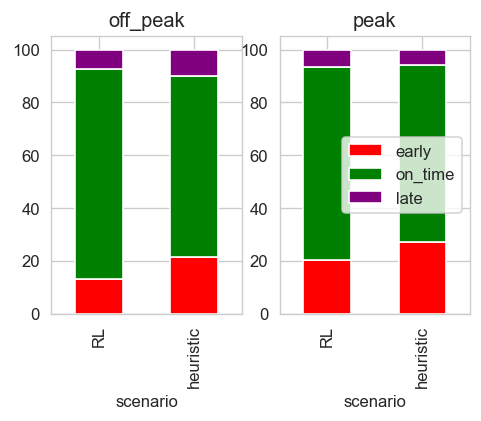

In [116]:
fig, axs = plt.subplots(figsize=(4.5, 3), nrows=1, ncols=2)

# off peak scenario
for i, demand in enumerate(['off_peak', 'peak']):
    tmp_df = trip_counts[trip_counts['demand'] == demand].copy()
    tmp_df['scenario'] = tmp_df['scenario'].apply(lambda x: 'RL' if 'dqn' in x else 'heuristic')
    tmp_df = tmp_df[['scenario', 'early', 'on_time', 'late']]
    tmp_df = tmp_df.set_index('scenario')

    tmp_df.plot(kind='bar', stacked=True, ax=axs[i], color=['red', 'green', 'purple'])
    axs[i].set_title(demand)
    if i == 0:
        axs[i].legend().remove()

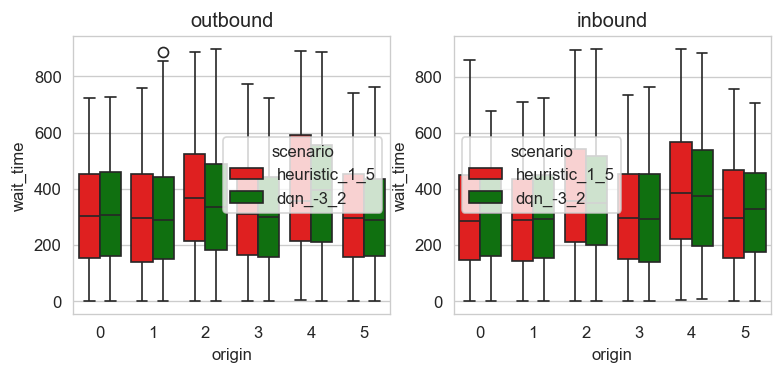

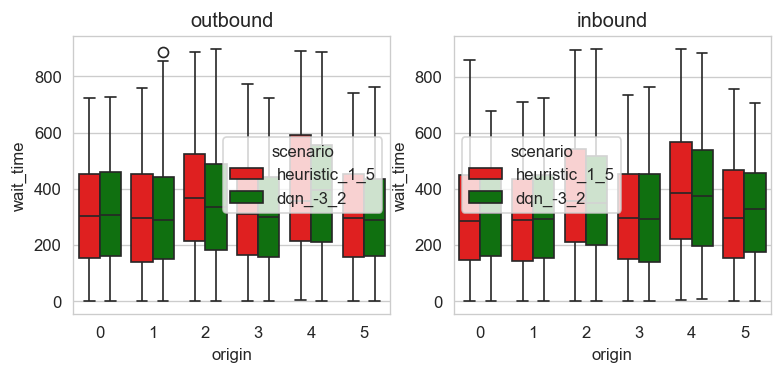

In [ ]:
for demand in ['off_peak', 'peak']:    
    tmp_df = eval_pax[eval_pax['demand'] == 'off_peak'].copy()

    tmp_out_df = tmp_df[tmp_df['direction'] == 'out'].copy()
    tmp_in_df = tmp_df[tmp_df['direction'] == 'in'].copy()

    fig, axs = plt.subplots(figsize=(7.5, 3), nrows=1, ncols=2)
    sns.boxplot(data=tmp_out_df, x='origin', y='wait_time', ax=axs[0], palette=['red', 'green'], hue='scenario')
    axs[0].set_title('outbound')
    sns.boxplot(data=tmp_in_df, x='origin', y='wait_time', ax=axs[1], palette=['red', 'green'], hue='scenario')
    axs[1].set_title('inbound')

In [18]:
osr_dist = get_on_schedule_rate_distributions(trips)
ar_dist = get_acceptance_rate_distributions(pax)

In [24]:
get_statistical_significance_test(
    osr_dist, 'dqn_3_5', 'slope_1_2', 'on_schedule_rate'
)

(1.392, 0.169)